# Spacecraft ADCS Assignment: Henry Adam

The purpose of this assignment is to gain experience with practical state estimation and control techniques for Spacecraft ADCS. That means working with imperfect sensors to get the best attitude control behavior possible from the system. 

### The tasks of the assignment are as follows: 

#### Part 1: Develope the complete dynamics and kinematics equations for the three-axis stablilized satellite

#### Part 2: Design Controller for rpy ctrl

#### Part 3: Simulate the performance of the controller w/ perfect attitude and angular velocity measurements(aka no sensor noise/bias)

#### Part 4: Simulate the performance of the controller w/ practical attitude and angular velocity measurementes(aka w/ noise and bias) 

#### Part 5: Design a structure of sensor integration in the case that gyro noise is zero

#### Part 6: Design a non-linear state estimateor for this integration structure to estimate the unknown gyro biases and filter out attitude sensor noises; 

#### Part 7: Integrate the state estimator in the s/c attitude ctrl loop

#### Part 8: Simulate the perforamce of the complete s/c attitude control loop

#### Part 9: Compare performance w/ and w/o the state estimator

# Part 0: Define all of the constants and givens of the system

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy import sin, cos, tan 
from scipy.linalg import expm 
# Define Constants
R_earth = 6378 #km 
mu  = 398600000000000 #m^3/s^2

#Define the parameters of the spacecraft
orbit_h = 700 #km 
n = np.sqrt(mu/(((orbit_h+R_earth)*1000)**3))

J = np.array([[2700, 0, 0], [0, 2300, 0], [0, 0, 3000]])
J11 = J[0,0]; J22 = J[1,1]; J33 = J[2,2]

#disturbance torques 
Md = np.array([0.001, 0.001, 0.001]).T  #N*m
Md1 = Md[0]; Md2 = Md[1]; Md3 = Md[2]

#Sensor Specifications
roll_err, pitch_err, yaw_err = 0.1, 0.1, 0.1 #deg
omega_x_err, omega_y_err, omega_z_err = 0.1, -0.1, 0.15 #deg/s 

#Requirements for tracking accuracy
roll_req, pitch_req, yaw_req = 0.1, 0.1, 0.1 #degrees 

#Reference angles
desired_roll, desired_pitch, desired_yaw = 0.0, 0.0, 0.0
desired_roll_rate, desired_yaw_rate, desired_pitch_rate = 0.0, 0.0, 0.0 

#initial condition(attitude errors in degrees)
initial_roll, initial_pitch, initial_yaw = 5.0, 5.0, 5.0


# Part 1-3: Derive and Simulate System Dynamics, Create Linear Controller

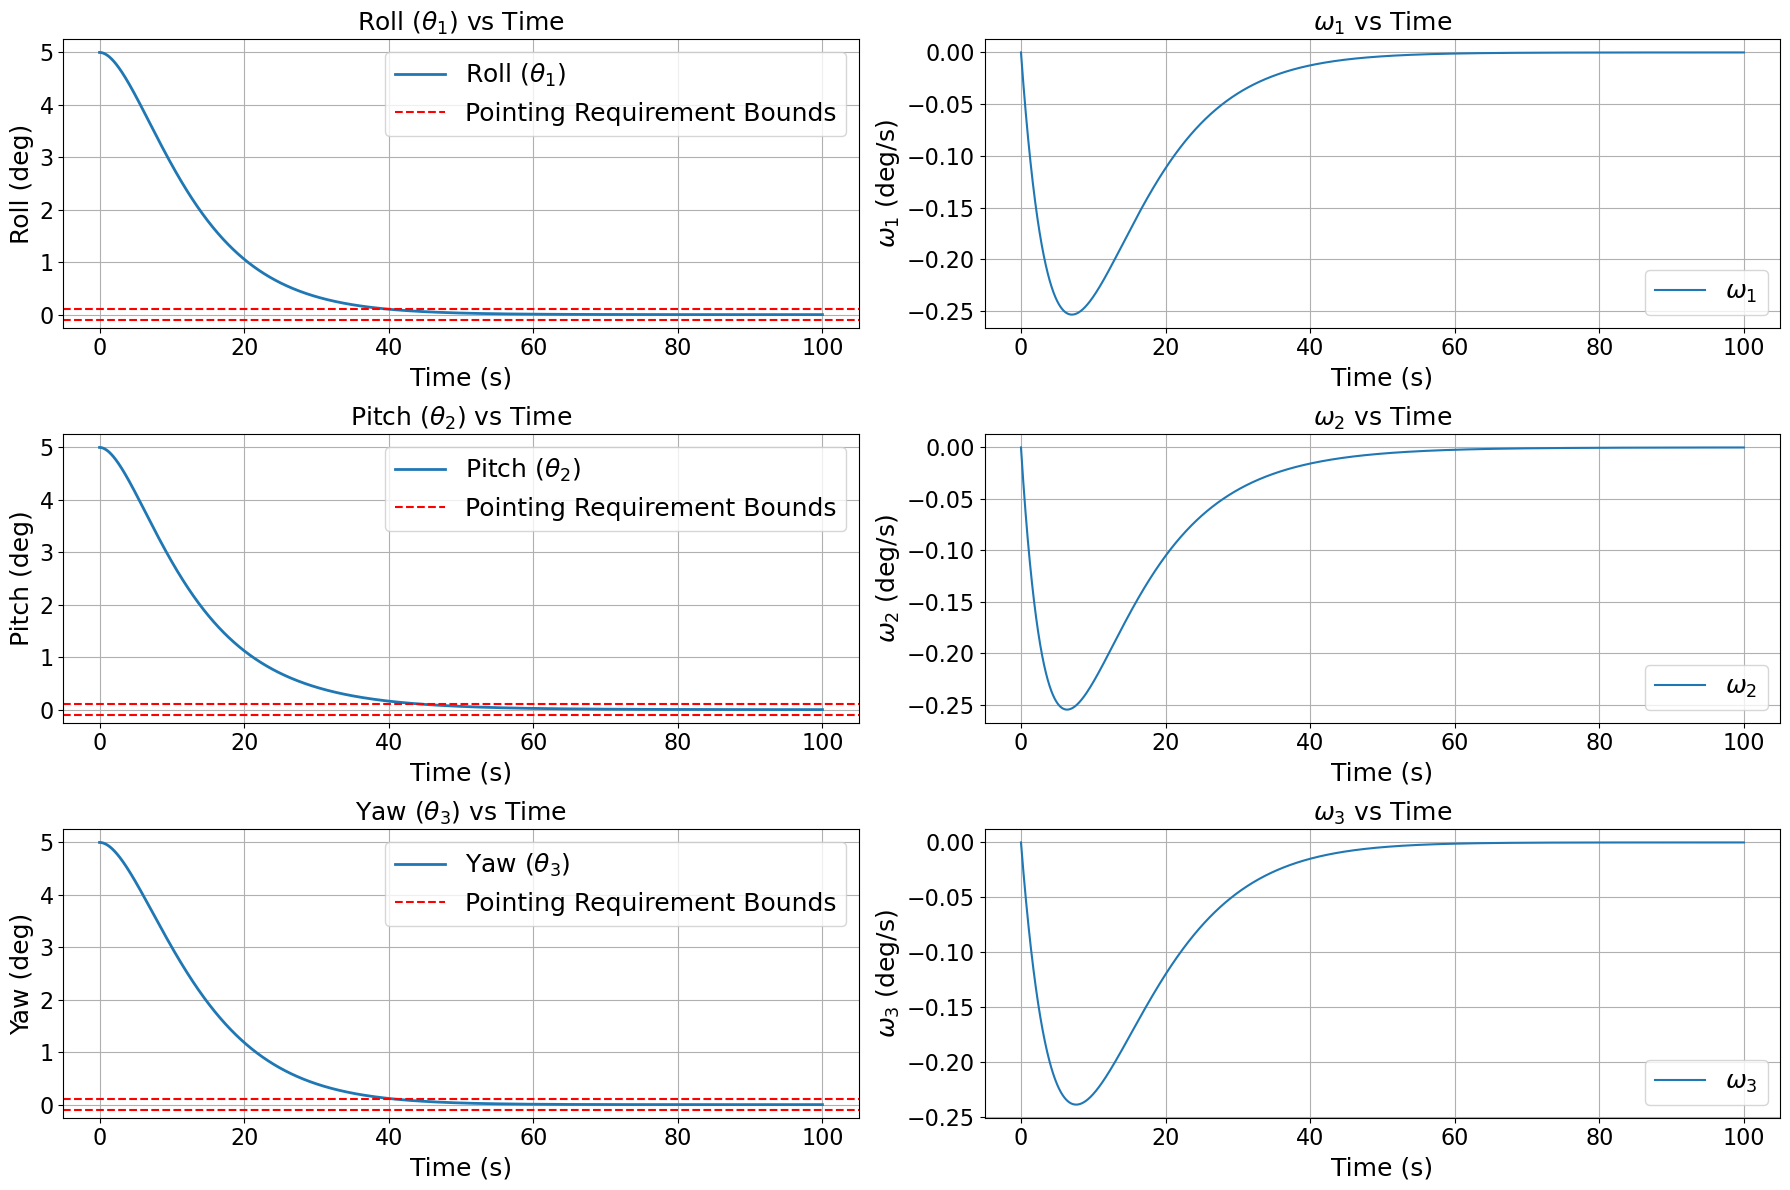

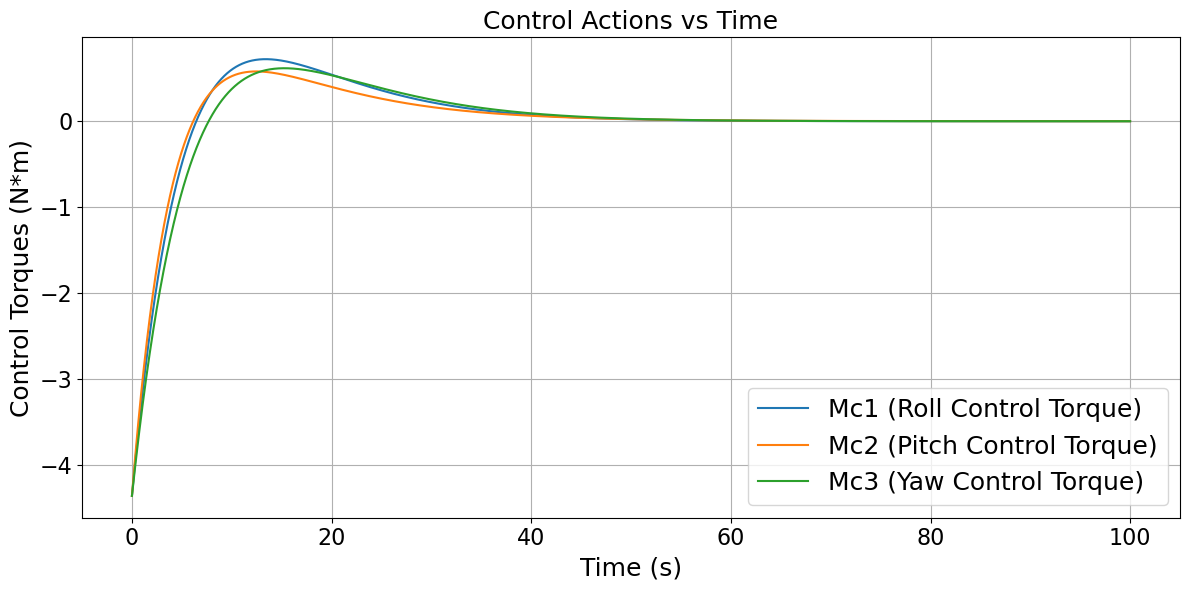

In [2]:
#assume we have ideal thrusters w/ no torque limit and instantaneous control action

#set up sim parameters
t_sim = 100 #s
dt = 0.01 #s 
N = int(t_sim/dt) #number of timesteps

#assuming the state vector consists of [θ1, θ2, θ3, omega_1, omega_2, omega_3]
x = np.array([initial_roll * (np.pi/180), initial_pitch * (np.pi/180), initial_yaw * (np.pi/180), 0.0, 0.0, 0.0]).T 

def get_control_action(current_state, control=True):
    #Use the current state to calculate the control action for the next state
    #Using simple PD controller for now(proportional and rate control for each state). E.g. Mc1 = Kp1 * theta1 + Kd1 * theta1_dot
    #tune these to make the system converge as desired
    Kp1 = -50; Kp2 = -50; Kp3 = -50; # Kp1 = -2600; Kp2 = -2300; Kp3 = -3000; 
    Kd1 = -750; Kd2 = -750; Kd3 = -750; # Kd1 = -4160; Kd2 = -3680; Kd3 = -4800;

    Kp = np.diag([Kp1, Kp2, Kp3])
    Kd = np.diag([Kd1, Kd2, Kd3])
    thetas = current_state[0:3] 
    omegas = current_state[3:6]

    Ms = Kp @ thetas + Kd @ omegas

    if control:
        return Ms
    else:
        return np.array([0, 0, 0])

def get_derivatives(x, Md, Ma):
    #pull individual states from state matrix
    theta1 = x[0]; theta2 = x[1]; theta3 = x[2]; omega1 = x[3]; omega2 = x[4]; omega3 = x[5]
    # pull control and disturbance torques
    Md1 = Md[0]; Md2 = Md[1]; Md3 = Md[2]; 
    Ma1 = Ma[0]; Ma2 = Ma[1]; Ma3 = Ma[2]; 

    #get the derivatives of each state
    theta1_dot = omega1 + (omega2 * sin(theta1) + omega3 * cos(theta1)) * tan(theta2)
    theta2_dot = omega2 * cos(theta1) + omega3 * sin(theta1)
    theta3_dot = (omega2 * sin(theta1) + omega3 * cos(theta1)) / cos(theta2)
    omega1_dot = (Ma1 + Md1 - 3 * n * (J33 - J22) * cos(theta1) * sin(theta1) * (cos(theta2)**2) - (J33 - J22) * omega2 * omega3)/J11 
    omega2_dot = (Ma2 + Md2 - 3 * n * (J33 - J11) * cos(theta1) * cos(theta2) * sin(theta2) - (J11 - J33) * omega1 * omega3)/J22
    omega3_dot = (Ma3 + Md3 + 3 * n * (J11 - J22) * sin(theta1) * sin(theta2) * cos(theta2) - (J22 - J11) * omega1 * omega2)/J33 

    #combine all derivatives
    x_dot = np.array([theta1_dot, theta2_dot, theta3_dot, omega1_dot, omega2_dot, omega3_dot]).T
    if len(x) == 6:
        #for traditional measured state w/o EKF
        return x_dot
    if len(x) == 9: 
        #for augmented state in EKF implementation
        return np.vstack([x_dot.reshape(6, 1), np.zeros((3,1))])

def plot_everything(times, states, noisy_states, control_torques):
    # Plotting The Simulation
    fig, axs = plt.subplots(3, 2, figsize=(18, 12))

    # Roll 
    if noisy_states is not None:
        axs[0, 0].plot(times, noisy_states[0, :] * (180/np.pi), label=r'$\theta_1$ Measurement', linestyle=':', linewidth=1.5)
    axs[0, 0].plot(times, states[0, :] * (180/np.pi), label=r'Roll ($\theta_1$)', linewidth=2)
    axs[0, 0].axhline(0.1, color='r', linestyle='--', label='Pointing Requirement Bounds')
    axs[0, 0].axhline(-0.1, color='r', linestyle='--')
    axs[0, 0].set_title(r'Roll ($\theta_1$) vs Time', fontsize=18)
    axs[0, 0].set_xlabel('Time (s)', fontsize=18)
    axs[0, 0].set_ylabel('Roll (deg)', fontsize=18)
    axs[0, 0].legend(fontsize=18)
    axs[0, 0].grid()

    # Pitch 
    if noisy_states is not None:
        axs[1, 0].plot(times, noisy_states[1, :] * (180/np.pi), label=r'$\theta_2$ Measurement', linestyle=':', linewidth=0.8)
    axs[1, 0].plot(times, states[1, :] * (180/np.pi), label=r'Pitch ($\theta_2$)', linewidth=2)
    axs[1, 0].axhline(0.1, color='r', linestyle='--', label='Pointing Requirement Bounds')
    axs[1, 0].axhline(-0.1, color='r', linestyle='--')
    axs[1, 0].set_title(r'Pitch ($\theta_2$) vs Time', fontsize=18)
    axs[1, 0].set_xlabel('Time (s)', fontsize=18)
    axs[1, 0].set_ylabel('Pitch (deg)', fontsize=18)
    axs[1, 0].legend(fontsize=18)
    axs[1, 0].grid()

    # Yaw
    if noisy_states is not None:
        axs[2, 0].plot(times, noisy_states[2, :] * (180/np.pi), label=r'$\theta_3$ Measurement', linestyle=':', linewidth=0.8)
    axs[2, 0].plot(times, states[2, :] * (180/np.pi), label=r'Yaw ($\theta_3$)', linewidth=2)
    axs[2, 0].axhline(0.1, color='r', linestyle='--', label='Pointing Requirement Bounds')
    axs[2, 0].axhline(-0.1, color='r', linestyle='--')
    axs[2, 0].set_title(r'Yaw ($\theta_3$) vs Time', fontsize=18)
    axs[2, 0].set_xlabel('Time (s)', fontsize=18)
    axs[2, 0].set_ylabel('Yaw (deg)', fontsize=18)
    axs[2, 0].legend(fontsize=18)
    axs[2, 0].grid()

    # Roll Rate 
    axs[0, 1].plot(times, states[3, :] * (180/np.pi), label=r'$\omega_1$')
    if noisy_states is not None:
        axs[0, 1].plot(times, noisy_states[3, :] * (180/np.pi), label=r'$\omega_1$ Measurement', linestyle=':', linewidth=1.5)
    axs[0, 1].set_title(r'$\omega_1$ vs Time', fontsize=18)
    axs[0, 1].set_xlabel('Time (s)', fontsize=18)
    axs[0, 1].set_ylabel(r'$\omega_1$ (deg/s)', fontsize=18)
    axs[0, 1].legend(fontsize=18)
    axs[0, 1].grid()

    # Pitch Rate 
    axs[1, 1].plot(times, states[4, :] * (180/np.pi), label=r'$\omega_2$')
    if noisy_states is not None:
        axs[1, 1].plot(times, noisy_states[4, :] * (180/np.pi), label=r'$\omega_2$ Measurement', linestyle=':', linewidth=1.5)
    axs[1, 1].set_title(r'$\omega_2$ vs Time', fontsize=18)
    axs[1, 1].set_xlabel('Time (s)', fontsize=18)
    axs[1, 1].set_ylabel(r'$\omega_2$ (deg/s)', fontsize=18)
    axs[1, 1].legend(fontsize=18)
    axs[1, 1].grid()

    # Yaw Rate 
    axs[2, 1].plot(times, states[5, :] * (180/np.pi), label=r'$\omega_3$')
    if noisy_states is not None:
        axs[2, 1].plot(times, noisy_states[5, :] * (180/np.pi), label=r'$\omega_3$ Measurement', linestyle=':', linewidth=1.5)
    axs[2, 1].set_title(r'$\omega_3$ vs Time', fontsize=18)
    axs[2, 1].set_xlabel('Time (s)', fontsize=18)
    axs[2, 1].set_ylabel(r'$\omega_3$ (deg/s)', fontsize=18)
    axs[2, 1].legend(fontsize=18)
    axs[2, 1].grid()

    # Tick labels size
    for ax in axs.flatten():
        ax.tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    if noisy_states is not None:
        plt.savefig('Noisy_Response_Plots.pdf')
    else:
        plt.savefig('Ideal_Response_Plots.pdf')
    plt.show()

    # Plot control actions in a separate figure
    plt.figure(figsize=(12, 6))
    plt.plot(times, control_torques[0, :], label='Mc1 (Roll Control Torque)')
    plt.plot(times, control_torques[1, :], label='Mc2 (Pitch Control Torque)')
    plt.plot(times, control_torques[2, :], label='Mc3 (Yaw Control Torque)')
    plt.title('Control Actions vs Time', fontsize=18)
    plt.xlabel('Time (s)', fontsize=18)
    plt.ylabel('Control Torques (N*m)', fontsize=18)
    plt.legend(fontsize=18)
    plt.grid()
    plt.tick_params(axis='both', labelsize=16)
    plt.tight_layout()
    if noisy_states is not None:
        plt.savefig('Noisy_Control_Plots.pdf')
    else:
        plt.savefig('Ideal_Control_Plots.pdf')
    plt.show()
    return

def simulate_sc(init_state, measure_state=None, plotting=True):
    #Integrate over all timesteps(ideal case)
    #Set up sim variables
    times = np.zeros(N)
    states = np.zeros((6, N))
    control_torques = np.zeros((3, N))
    #only allocate memory for noisy states if we're using noise
    if not (measure_state is None): 
        noisy_states = np.zeros((6, N))
    else: 
        noisy_states = None

    #Initializing 
    time = 0 
    x = init_state

    for i in range(N):
        #Save variables to plot
        times[i] = time
        states[:, i] = x #Save state in degrees, do calculations in radians
        
        #First, use the current state to get the control action. Using a PD controller
        if measure_state is None:
            Mc = get_control_action(x)
        else: 
            noisy_state = measure_state(x)
            noisy_states[:, i] = noisy_state
            Mc = get_control_action(noisy_state)

        control_torques[:, i] = Mc.T 
        

        #integrate system dynamics
        x_dot = get_derivatives(x, Md, Mc)
        delta_x = x_dot * dt

        #update the system state
        x = x + delta_x

        time += dt

    if plotting: 
        plot_everything(times, states, noisy_states, control_torques)
    return times, states, noisy_states, control_torques

#no need to save the variables for now
_, _, _, _ = simulate_sc(x)


## Part 4: Integrate Practical Sensor Noise Effects

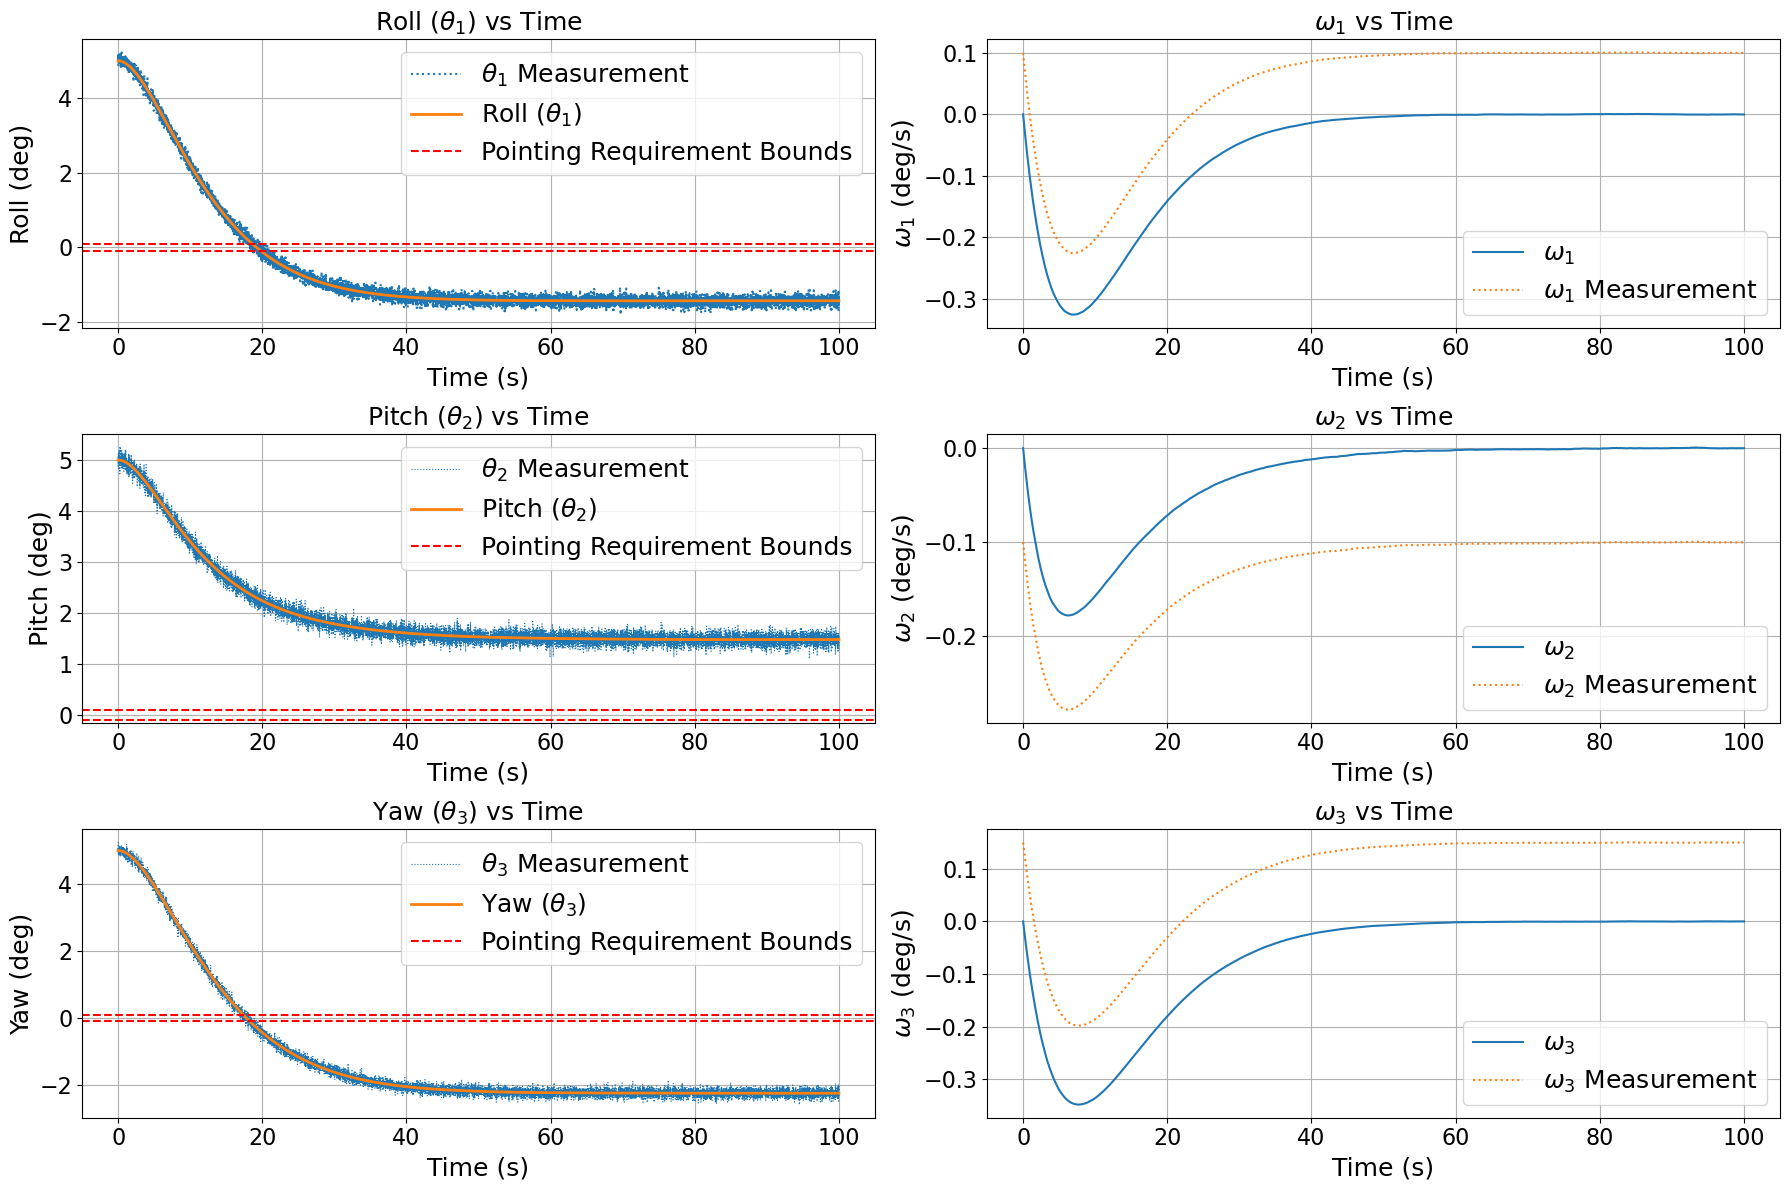

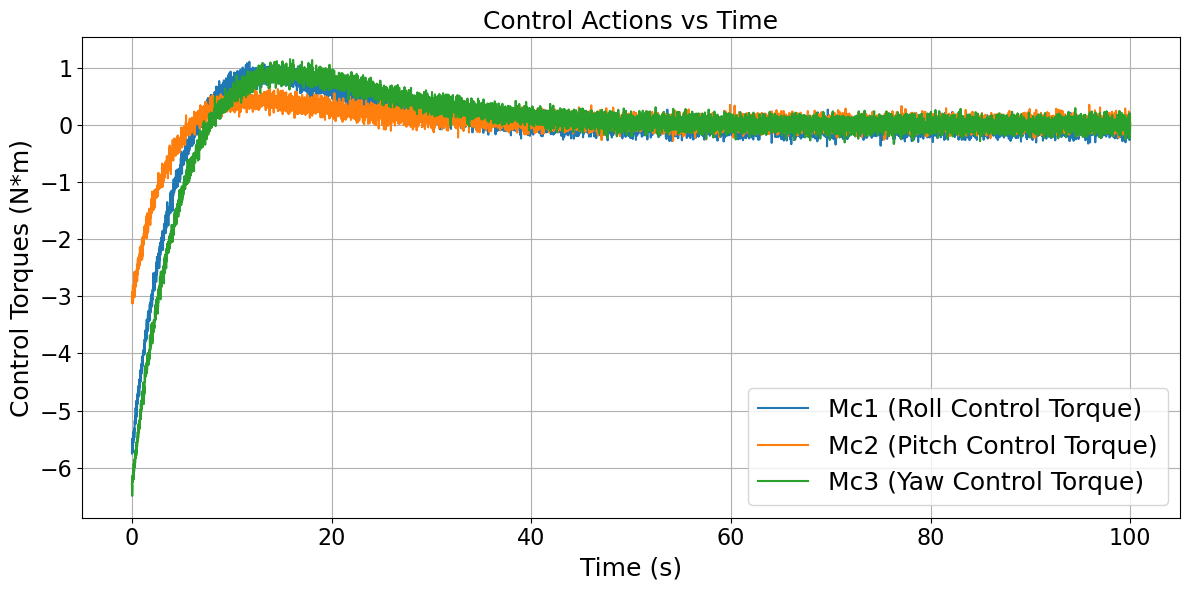

In [3]:
def measure_state(state):
    #Add sensor noise to the measurements for each state

    # Add random Gaussian noise with a standard deviation equal to the sensor errors for position
    noisy_state = np.zeros(np.shape(state))
    attitude_error_std = np.array([roll_err, pitch_err, yaw_err]) * (np.pi/180) # Radians
    noisy_state[0:3] = state[0:3] + np.random.normal(0, attitude_error_std, state[0:3].shape)

    #Add angular velocity error as a constant bias
    velocity_bias = np.array([omega_x_err, omega_y_err, omega_z_err]).T * (np.pi/180)
    
    noisy_state[3:6] = state[3:6] + velocity_bias
    
    return noisy_state

_, _, _, _ = simulate_sc(x, measure_state)

## Part 5-8: Design a Structure of Sensor Integration, EKF State Estimation, Integrate into Control Loop, Simulate Performance

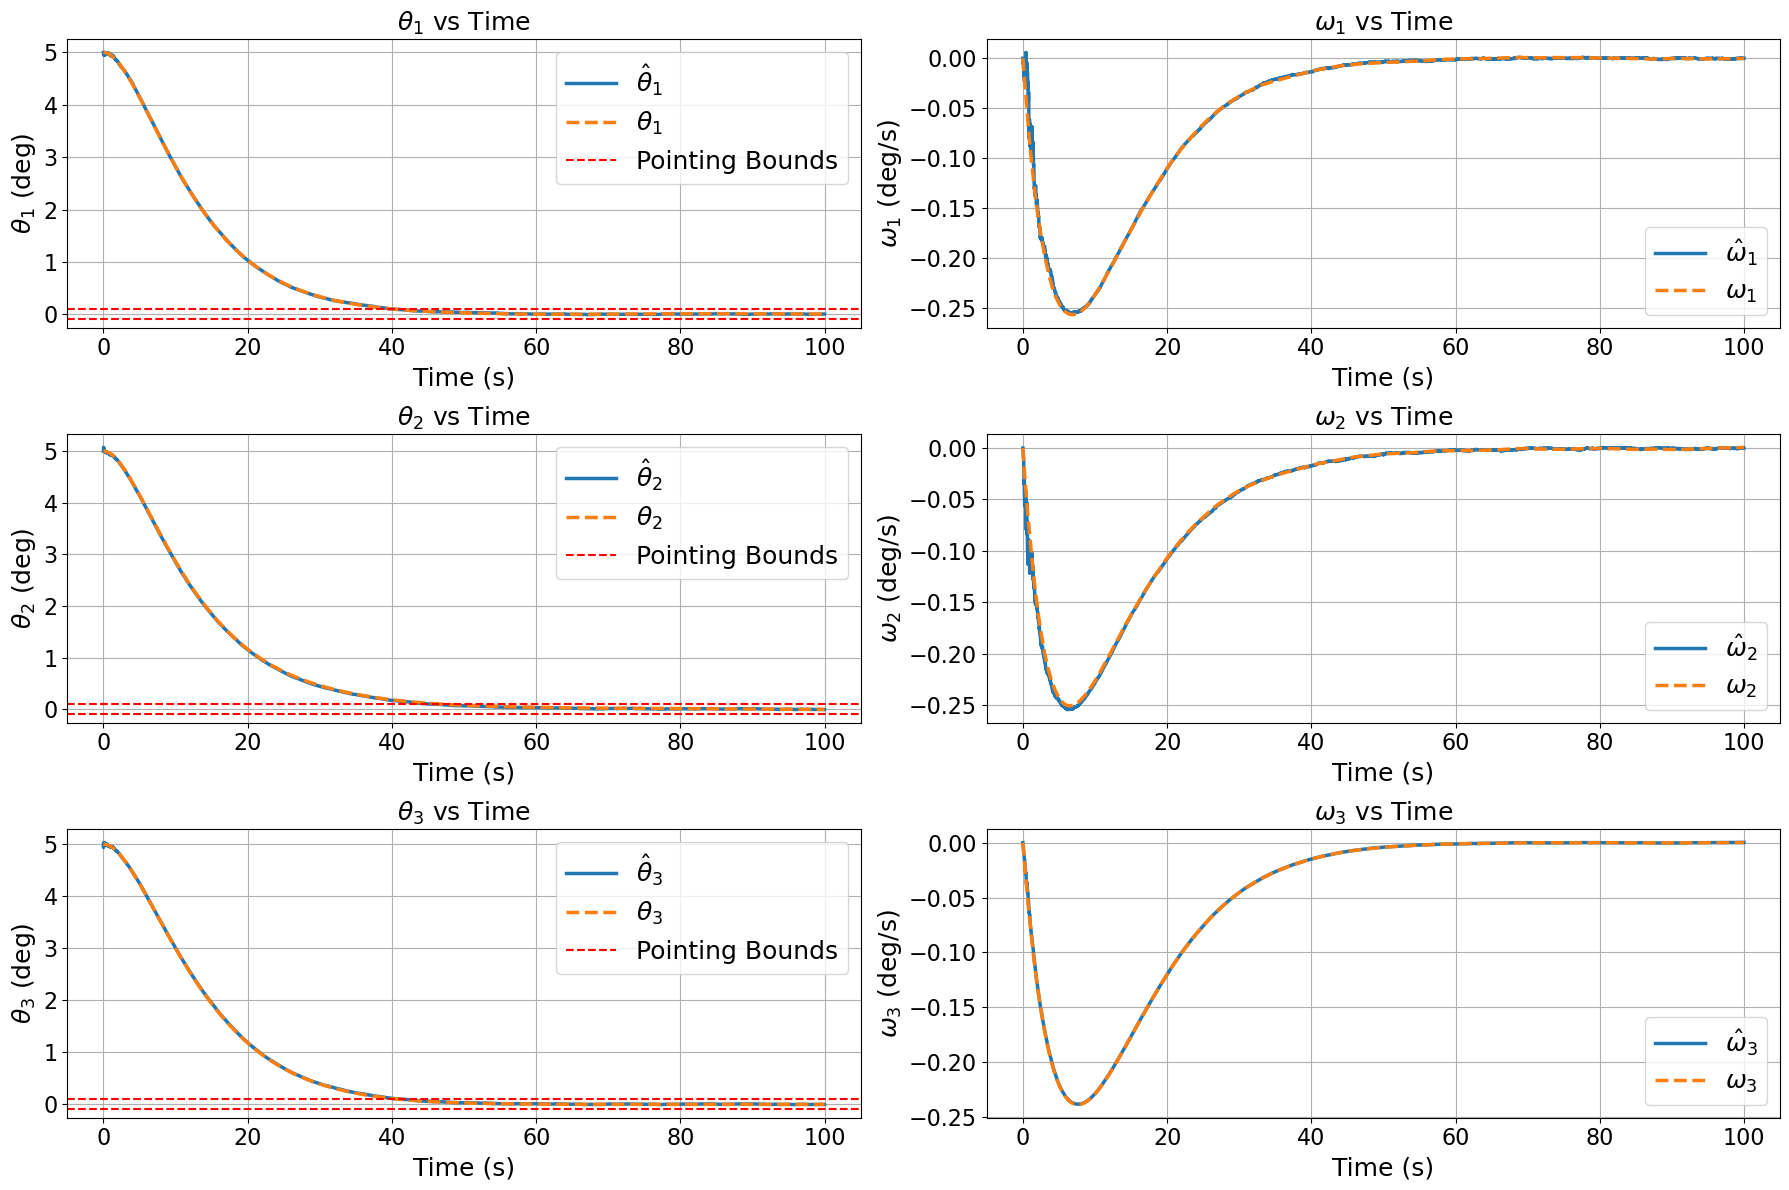

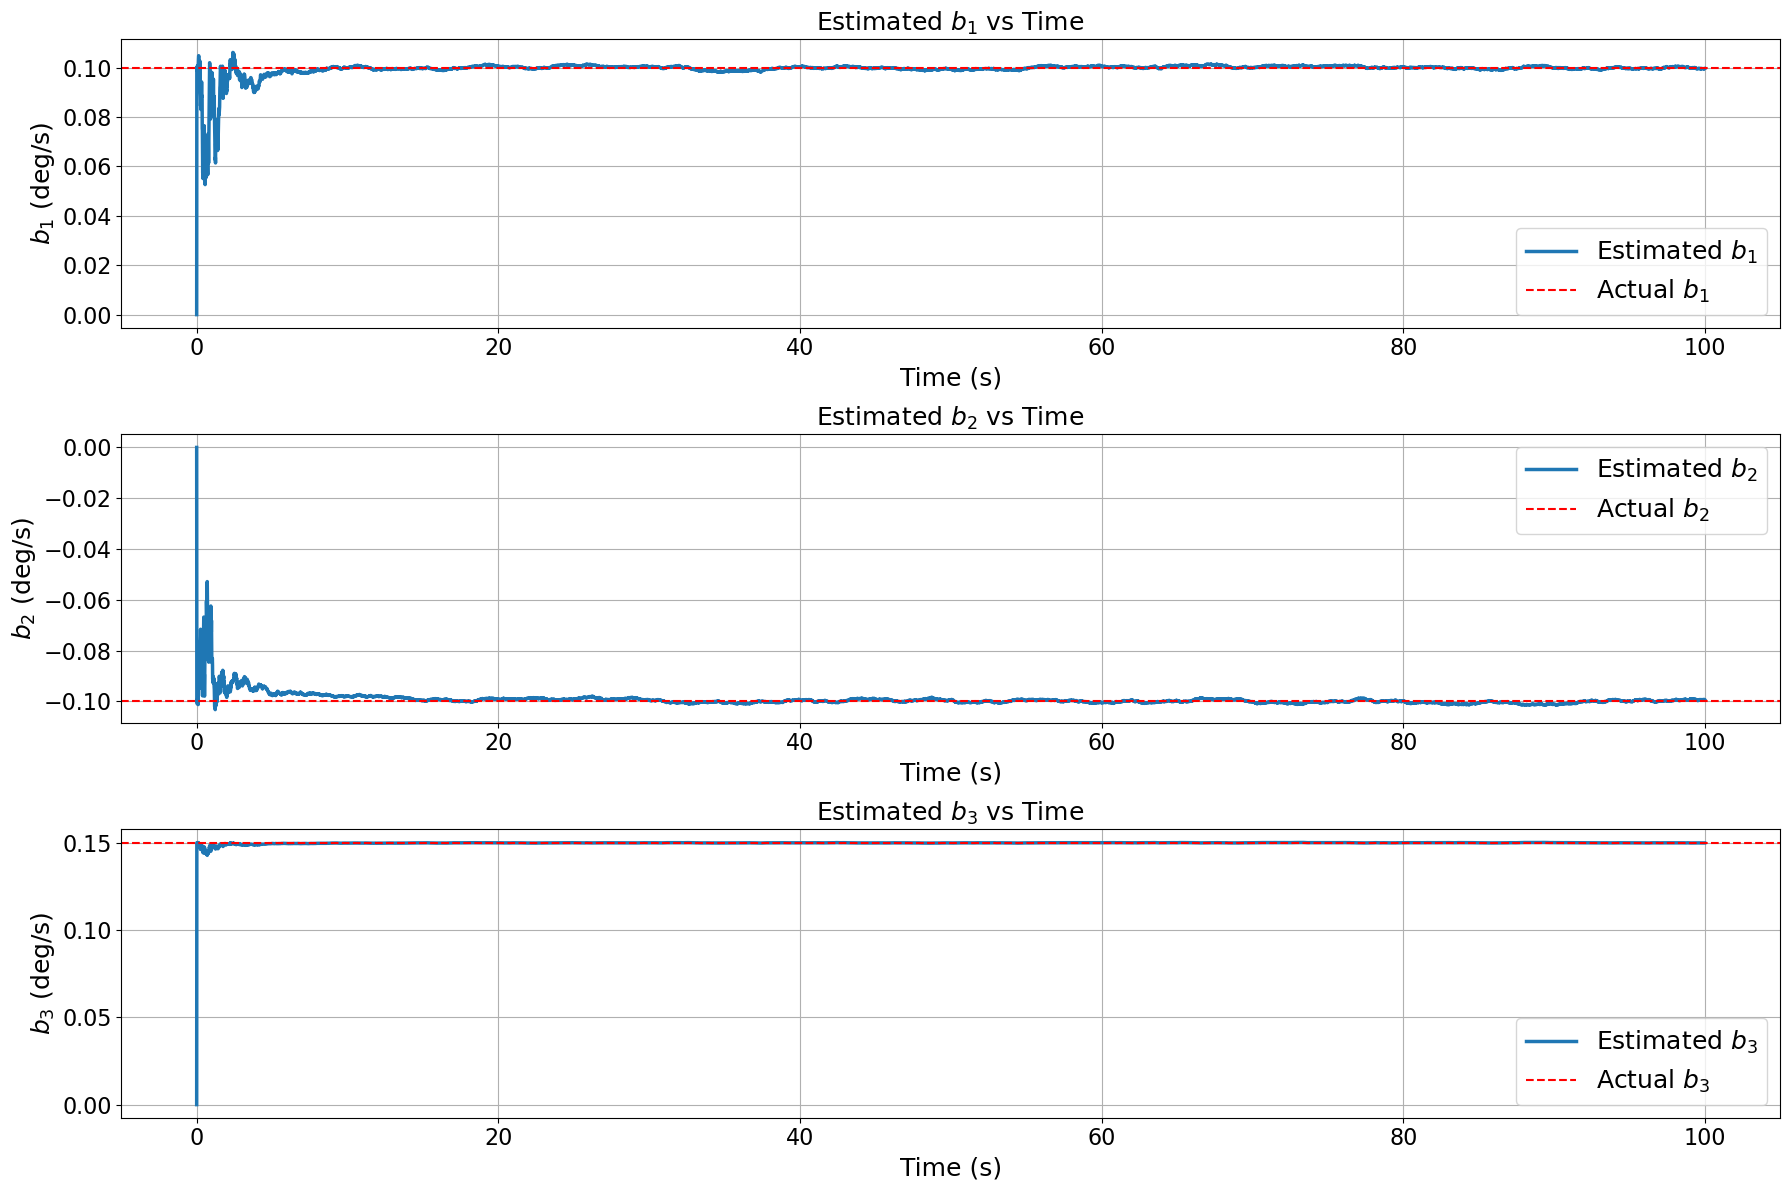

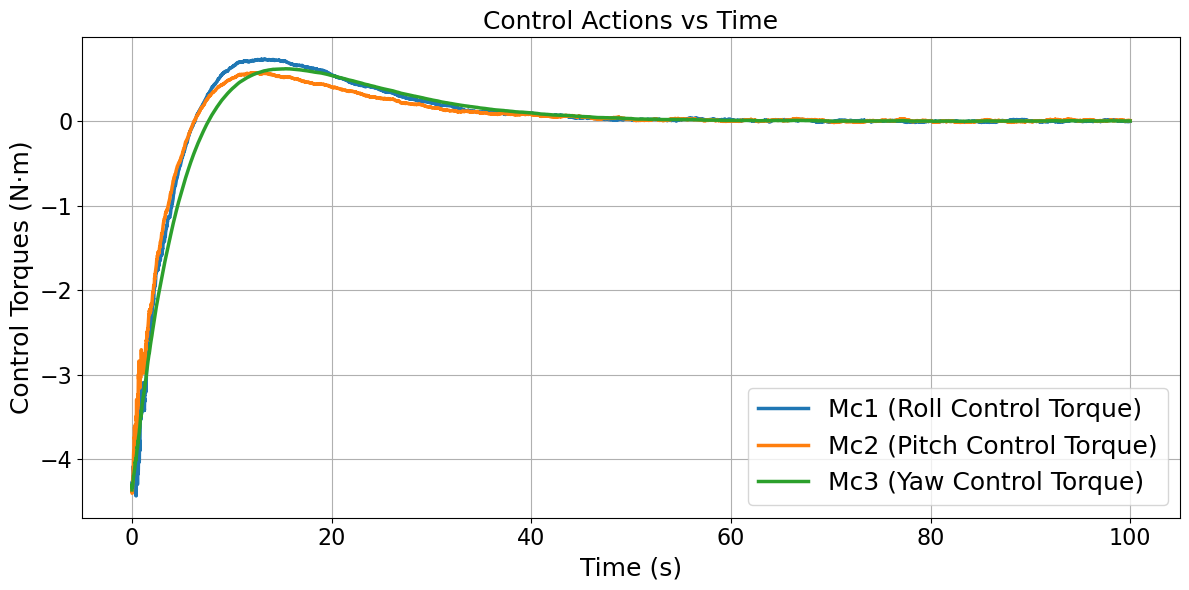

In [4]:
def plot_everything_EKF(times, states, noisy_states, control_torques, estimated_states):
    # Plotting The Simulation
    noisy_states = None

    fig, axs = plt.subplots(3, 2, figsize=(18, 12))

    # Roll Plots
    axs[0, 0].plot(times, estimated_states[0, :] * (180/np.pi), label=r'$\hat{\theta}_1$', linewidth=2.5)
    axs[0, 0].plot(times, states[0, :] * (180/np.pi), linestyle="--", label=r'$\theta_1$', linewidth=2.5)
    if noisy_states is not None:
        axs[0, 0].plot(times, noisy_states[0, :] * (180/np.pi), label=r'$\theta_1$ measurement', linestyle=':', linewidth=2.5)
    axs[0, 0].axhline(0.1, color='r', linestyle='--', label='Pointing Bounds')
    axs[0, 0].axhline(-0.1, color='r', linestyle='--')
    axs[0, 0].set_title(r'$\theta_1$ vs Time', fontsize=18)
    axs[0, 0].set_xlabel('Time (s)', fontsize=18)
    axs[0, 0].set_ylabel(r'$\theta_1$ (deg)', fontsize=18)
    axs[0, 0].legend(fontsize=18)
    axs[0, 0].grid()

    # Pitch Plots
    axs[1, 0].plot(times, estimated_states[1, :] * (180/np.pi), label=r'$\hat{\theta}_2$', linewidth=2.5)
    axs[1, 0].plot(times, states[1, :] * (180/np.pi), linestyle="--", label=r'$\theta_2$', linewidth=2.5)
    if noisy_states is not None:
        axs[1, 0].plot(times, noisy_states[1, :] * (180/np.pi), label=r'$\theta_2$ measurement', linestyle=':', linewidth=2.5)
    axs[1, 0].axhline(0.1, color='r', linestyle='--', label='Pointing Bounds')
    axs[1, 0].axhline(-0.1, color='r', linestyle='--')
    axs[1, 0].set_title(r'$\theta_2$ vs Time', fontsize=18)
    axs[1, 0].set_xlabel('Time (s)', fontsize=18)
    axs[1, 0].set_ylabel(r'$\theta_2$ (deg)', fontsize=18)
    axs[1, 0].legend(fontsize=18)
    axs[1, 0].grid()

    # Yaw Plots
    axs[2, 0].plot(times, estimated_states[2, :] * (180/np.pi), label=r'$\hat{\theta}_3$', linewidth=2.5)
    axs[2, 0].plot(times, states[2, :] * (180/np.pi), linestyle="--", label=r'$\theta_3$', linewidth=2.5)
    if noisy_states is not None:
        axs[2, 0].plot(times, noisy_states[2, :] * (180/np.pi), label=r'$\theta_3$ measurement', linestyle=':', linewidth=2.5)
    axs[2, 0].axhline(0.1, color='r', linestyle='--', label='Pointing Bounds')
    axs[2, 0].axhline(-0.1, color='r', linestyle='--')
    axs[2, 0].set_title(r'$\theta_3$ vs Time', fontsize=18)
    axs[2, 0].set_xlabel('Time (s)', fontsize=18)
    axs[2, 0].set_ylabel(r'$\theta_3$ (deg)', fontsize=18)
    axs[2, 0].legend(fontsize=18)
    axs[2, 0].grid()

    # Roll Rate Plots
    axs[0, 1].plot(times, estimated_states[3, :] * (180/np.pi), label=r'$\hat{\omega}_1$', linewidth=2.5)
    axs[0, 1].plot(times, states[3, :] * (180/np.pi), linestyle="--", label=r'$\omega_1$', linewidth=2.5)
    if noisy_states is not None:
        axs[0, 1].plot(times, noisy_states[3, :] * (180/np.pi), label=r'$\omega_1$ measurement', linestyle=':', linewidth=2.5)
    axs[0, 1].set_title(r'$\omega_1$ vs Time', fontsize=18)
    axs[0, 1].set_xlabel('Time (s)', fontsize=18)
    axs[0, 1].set_ylabel(r'$\omega_1$ (deg/s)', fontsize=18)
    axs[0, 1].legend(fontsize=18)
    axs[0, 1].grid()

    # Pitch Rate Plots
    axs[1, 1].plot(times, estimated_states[4, :] * (180/np.pi), label=r'$\hat{\omega}_2$', linewidth=2.5)
    axs[1, 1].plot(times, states[4, :] * (180/np.pi), linestyle="--", label=r'$\omega_2$', linewidth=2.5)
    if noisy_states is not None:
        axs[1, 1].plot(times, noisy_states[4, :] * (180/np.pi), label=r'$\omega_2$ measurement', linestyle=':', linewidth=2.5)
    axs[1, 1].set_title(r'$\omega_2$ vs Time', fontsize=18)
    axs[1, 1].set_xlabel('Time (s)', fontsize=18)
    axs[1, 1].set_ylabel(r'$\omega_2$ (deg/s)', fontsize=18)
    axs[1, 1].legend(fontsize=18)
    axs[1, 1].grid()

    # Yaw Rate Plots
    axs[2, 1].plot(times, estimated_states[5, :] * (180/np.pi), label=r'$\hat{\omega}_3$', linewidth=2.5)
    axs[2, 1].plot(times, states[5, :] * (180/np.pi), linestyle="--", label=r'$\omega_3$', linewidth=2.5)
    if noisy_states is not None:
        axs[2, 1].plot(times, noisy_states[5, :] * (180/np.pi), label=r'$\omega_3$ measurement', linestyle=':', linewidth=2.5)
    axs[2, 1].set_title(r'$\omega_3$ vs Time', fontsize=18)
    axs[2, 1].set_xlabel('Time (s)', fontsize=18)
    axs[2, 1].set_ylabel(r'$\omega_3$ (deg/s)', fontsize=18)
    axs[2, 1].legend(fontsize=18)
    axs[2, 1].grid()

    # Set tick label size
    for ax in axs.flatten():
        ax.tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.savefig('EKF_Response_Plots.pdf')
    plt.show()

    # Plot the estimated biases in separate figure
    fig, axs = plt.subplots(3, 1, figsize=(18, 12))
    labels = [r'$b_1$', r'$b_2$', r'$b_3$']
    errors = [omega_x_err, omega_y_err, omega_z_err]
    for idx in range(3):
        axs[idx].plot(times, estimated_states[6+idx, :] * (180/np.pi), label=f"Estimated {labels[idx]}", linewidth=2.5)
        axs[idx].axhline(errors[idx], color='r', linestyle='--', label=f'Actual {labels[idx]}')
        axs[idx].set_title(f'Estimated {labels[idx]} vs Time', fontsize=18)
        axs[idx].set_xlabel('Time (s)', fontsize=18)
        axs[idx].set_ylabel(rf'{labels[idx]} (deg/s)', fontsize=18)
        axs[idx].legend(fontsize=18)
        axs[idx].grid()
        axs[idx].tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.savefig('EKF_Bias_Estimate.pdf')
    plt.show()

    # Plot control actions in a separate figure
    fig_ctrl = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.plot(times, control_torques[0, :], label='Mc1 (Roll Control Torque)', linewidth=2.5)
    ax.plot(times, control_torques[1, :], label='Mc2 (Pitch Control Torque)', linewidth=2.5)
    ax.plot(times, control_torques[2, :], label='Mc3 (Yaw Control Torque)', linewidth=2.5)
    ax.set_title('Control Actions vs Time', fontsize=18)
    ax.set_xlabel('Time (s)', fontsize=18)
    ax.set_ylabel('Control Torques (N·m)', fontsize=18)
    ax.legend(fontsize=18)
    ax.grid()
    ax.tick_params(axis='both', labelsize=16)
    plt.tight_layout()
    plt.savefig('EKF_Control_Plots.pdf')
    plt.show()
    return
def measure_state_w_EKF(state):
    #Add sensor noise to the measurements for each state

    # Add random Gaussian noise with a standard deviation equal to the sensor errors for position
    noisy_state = np.zeros(np.shape(state))
    attitude_error_std = np.array([roll_err, pitch_err, yaw_err]) * (np.pi/180) # Radians
    noisy_state[0:3] = state[0:3] + np.random.normal(0, attitude_error_std.reshape(3,1), state[0:3].shape)

    #Add angular velocity error as a constant bias
    velocity_bias = np.array([omega_x_err, omega_y_err, omega_z_err]).T * (np.pi/180)
    noisy_state[3:6] = state[3:6] + velocity_bias.reshape(3,1)
    
    return noisy_state[0:6]

def get_control_action_w_bias(current_state, control=True):
    #Use the current state to calculate the control action for the next state
    #Using simple PD controller for now(proportional and rate control for each state). E.g. Mc1 = Kp1 * theta1 + Kd1 * theta1_dot
    #tune these to make the system converge as desired
    Kp1 = -50; Kp2 = -50; Kp3 = -50; # Kp1 = -2600; Kp2 = -2300; Kp3 = -3000; 
    Kd1 = -500; Kd2 = -500; Kd3 = -500; # Kd1 = -4160; Kd2 = -3680; Kd3 = -4800;

    Kp = np.diag([Kp1, Kp2, Kp3])
    Kd = np.diag([Kd1, Kd2, Kd3])
    thetas = current_state[0:3] 
    omegas = current_state[3:6]
    bias_estimate = current_state[6:9]

    Ms = Kp @ thetas + Kd @ (omegas-bias_estimate)

    if control:
        return Ms
    else:
        return np.array([0, 0, 0])
    
def simulate_w_EKF(init_state, measure_state=None,  plotting=True, zero_first_estimate=False):
    #Integrate over all timesteps(ideal case)
    #Set up sim variables
    times = np.zeros(N)
    states = np.zeros((9, N))
    estimated_states = np.zeros((9, N))
    control_torques = np.zeros((3, N))
    #only allocate memory for noisy states if we're using noise
    if not (measure_state is None): 
        noisy_states = np.zeros((6, N))
    else: 
        noisy_states = None

    #Initializing state
    time = 0 
    x = np.vstack([init_state.reshape(len(init_state), 1), np.zeros((3,1))])

    #Initializing for EKF: Assume starting with estimate at actual value
    #also add the gyro bias as a state 
    x_hat = x
    #x_hat = np.vstack([measure_state(x)[0:3], np.zeros((6,1))]) #Just checking this is also stable

    if zero_first_estimate:
        x_hat = np.zeros(np.shape(x)) # In case you want to start at x=0

    #Statistical Properties of the EKF: 
    omega_var = 1e-8 #suggested by the internet for numerical stability. Can experiment with this. 
    R = np.diag([(roll_err* (np.pi/180))**2, 
                 (pitch_err* (np.pi/180))**2, 
                 (yaw_err* (np.pi/180))**2, 
                 omega_var , 
                 omega_var , 
                 omega_var])

    #initializing the system error covariance(kinda like confidence in your system prediction). Can play around with these values a bit
    P_est = np.diag([
    (0.1 * np.pi/180)**2,   # decent uncertainty in initial θ (5°)
    (0.1 * np.pi/180)**2,   
    (0.1 * np.pi/180)**2,
    (1e-3)**2,            # small uncertainty in ω 
    (1e-3)**2,            
    (1e-3)**2,
    (0.1)**2,             # pretty big uncertainty in bias
    (0.1)**2,
    (0.1)**2
    ])

    # Setting the 
    q_theta_block = np.eye(3) * 0 
    q_omega_block = np.eye(3) * 1e-8
    q_bias_block = np.eye(3) * 1e-10

    Q_cont = np.vstack([np.hstack([q_theta_block, np.zeros((3,3)),np.zeros((3,3))]),
                       np.hstack([np.zeros((3,3)), q_omega_block, np.zeros((3,3))]),
                       np.hstack([np.zeros((3,3)), np.zeros((3,3)), q_bias_block])])#NEED TO SET Q HERE!!!
    
    Q = Q_cont * dt #converting contriniuous-time Q to discrete-time Q

    for i in range(N):
        
        #Save variables to plot
        times[i] = time
        states[:, i] = x.flatten() #Save state 
        estimated_states[:, i] = x_hat.flatten()

        #now use the estimated x to get a control action
        Mc = get_control_action(x_hat)

        #Log the Control Actions
        control_torques[:, i] = Mc.T 

        #ACTUAL SYSTEM DYNAMICS(where the system actually is)
        x_dot = get_derivatives(x, Md, Mc)
        delta_x = x_dot * dt
        #update the actual system state (x_n+1 = x_n + δx)
        x = x + delta_x 
        
        #EKF Predict Step: Use the x from n-1 to predict the new x 
        x_pred, P_pred = ekf_predict(x_hat, Mc, P_est, Q)

        #EKF Correction Step: Combine the predicted state with the measurement for this state
        #First, get the measurement of the current state
        #print(x)
        measurement = measure_state(x)
        noisy_states[:, i] = measurement.flatten()

        #update the ekf measurment
        x_hat, P_est = ekf_update(x_pred, measurement, P_pred, Q, R)

        #update time
        time += dt

    if plotting: 
        plot_everything_EKF(times, states, noisy_states, control_torques, estimated_states)
    return times, states, estimated_states, noisy_states, control_torques

def ekf_predict(last_estimate, u, P_n_minus1, Q):
    #predict step of the EKF. See slide 44/45 of the estimation and sensing lecture

    #first predict the next timestep from the last estimate (linearized estimate)
    x_pred = last_estimate + get_derivatives(last_estimate, Md, u) * dt

    #now we want to update the associated error covariance matrix P to use in the update timestep
    #Get F(The jacobian of f(x))
    F = get_jacobian(x)

    #discrete-time dynamics matrix Phi(using scipy.linalg.expm for matrix exponential)
    Phi = expm(F * dt)

    #Predicted P(error covariance for system affectively)
    P_pred = Phi @ P_n_minus1 @ Phi.T + Q

    return x_pred, P_pred

def ekf_update(x_pred, x_meas, P_pred, Q, R):
    #Get H(jacobian of h(x), aka measurement/observation matrix)
    H = get_H()

    #Get Kalman Gain: 
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)

    #Update estimates for state and error covariance
    """print("x_meas: ", np.shape(x_meas))
    print("H: ", np.shape(H))
    print("x_pred: ", np.shape(x_pred))
    print("K: ", np.shape(K)) """
    x_hat = x_pred + K @ (x_meas - H @ x_pred)
    P_est = (np.eye(9) - K @ H) @ P_pred

    return x_hat, P_est

def get_H():
    H = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 1, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0, 1]])
    return H 

def get_jacobian(x_pred):
    #pull values from x 
    theta1 = x_pred[0]; theta2 = x_pred[1]; theta3 = x_pred[2]; omega1 = x_pred[3];  omega2 = x_pred[4];  omega3 = x_pred[5]; 

    #return the value of the jacobian so the P can be found 
    df1_dtheta1 = omega2 * cos(theta1) * tan(theta2) - omega3 * sin(theta1) * tan(theta2); df1_dtheta2 = (omega2 * sin(theta1) + omega3 * cos(theta1)) * ((1/cos(theta2)) ** 2); df1_dtheta3 = 0; df1_domega1 = 1; df1_domega2 = sin(theta1) * tan(theta2); df1_domega3 = cos(theta1) * tan(theta2); 
    df2_dtheta1 = -omega2 * sin(theta1) - omega3 * cos(theta1); df2_dtheta2 = 0; df2_dtheta3 = 0; df2_domega1 = 0; df2_domega2 = cos(theta1); df2_domega3 = -sin(theta1); 
    df3_dtheta1 = (omega2 * cos(theta1)) / cos(theta2); df3_dtheta2 = (omega2 * cos(theta1) - omega3 * sin(theta1)) * tan(theta2) * (1/cos(theta2)); df3_dtheta3 = 0; df3_domega1 = 0; df3_domega2 = cos(theta1)/cos(theta2); df3_domega3 = -sin(theta1)/cos(theta2); 
    df4_dtheta1 = (-3 * n * (J33 -J22))/(J11) * cos(2 * theta1) * (cos(theta2) ** 2); df4_dtheta2 = (-3 * n * (J33 - J22))/J11 * cos(theta1) * sin(theta1) * (-sin(2 * theta2)); df4_dtheta3 = 0; df4_domega1 = 0; df4_domega2 = (-(J33 -J22) * omega3)/J11; df4_domega3 = (-(J33 -J22) * omega2)/J11; 
    df5_dtheta1 = (-(3 * n * (J33 -J11))/J22) * sin(theta1) * cos(theta2) * sin(theta2); df5_dtheta2 = ((3 * n * (J33-J11))/J22) * cos(theta1) * cos(2 * theta2); df5_dtheta3 = 0; df5_domega1 = (-(J11-J33)/J22) * omega3; df5_domega2 = 0; df5_domega3 = (-(J11-J33)/J22) * omega3; 
    df6_dtheta1 = ((3 * n * (J11 - J22))/J33) * cos(theta1) * sin(theta2) * cos(theta2); df6_dtheta2 = ((3 * n * (J11 - J22))/J33) * sin(theta1) * cos(2 * theta2); df6_dtheta3 = 0; df6_domega1 = (-(J22 - J11)/J33) * omega2; df6_domega2 = (-(J22 - J11)/J33) * omega1; df6_domega3 = 0; 

    #Collect non-zero elements of the jacobian 
    jacobian_base = np.array([[df1_dtheta1, df1_dtheta2, df1_dtheta3, df1_domega1, df1_domega2, df1_domega3],
                             [df2_dtheta1, df2_dtheta2, df2_dtheta3, df2_domega1, df2_domega2, df2_domega3],
                             [df3_dtheta1, df3_dtheta2, df3_dtheta3, df3_domega1, df3_domega2, df3_domega3],
                             [df4_dtheta1, df4_dtheta2, df4_dtheta3, df4_domega1, df4_domega2, df4_domega3],
                             [df5_dtheta1, df5_dtheta2, df5_dtheta3, df5_domega1, df5_domega2, df5_domega3],
                             [df6_dtheta1, df6_dtheta2, df6_dtheta3, df6_domega1, df6_domega2, df6_domega3]])
    
    full_jacobian = np.vstack([np.hstack([jacobian_base, np.zeros((6, 3))]), np.zeros((3, 9))])

    return full_jacobian

_, _, _, _, _ = simulate_w_EKF(x.T, measure_state_w_EKF)

## Part 9: Comparing Results

In [5]:
#Outputting all the staes from the simulation w/ and w/o EKF 
#First in the ideal sensor case: 
times_ideal, states_ideal, noisy_states_ideal, control_torques_ideal = simulate_sc(x, measure_state=None, plotting=False)
#now with realistic sensors but no EKF
times, states, noisy_states, control_torques = simulate_sc(x, measure_state, plotting=False)

times_EKF, states_EKF, estimated_states_EKF, noisy_states_EKF, control_torques_EKF = simulate_w_EKF(x.T, measure_state_w_EKF, plotting=False)

#For Statistical Analysis: 
actual_biases = np.vstack([(np.pi/180)*omega_x_err * np.ones((1,len(times_ideal))), (np.pi/180)*omega_y_err * np.ones((1,len(times_ideal))),(np.pi/180)*omega_z_err * np.ones((1,len(times_ideal)))])

avg_diff_thetas_1 = np.mean(np.abs(states_EKF[0:3, :] - estimated_states_EKF[0:3, :]))
avg_diff_omegas_1 = np.mean(np.abs(states_EKF[3:6, :] - estimated_states_EKF[3:6, :]))
avg_diff_bias_1   = np.mean(np.abs(actual_biases - estimated_states_EKF[6:9, :]))
print(f"Average Diff in Theta: {avg_diff_thetas_1 * (180/np.pi)} deg\nAverage Diff in Omegas: {avg_diff_omegas_1 * (180/np.pi)} deg/s\nAverage Diff in biases: {avg_diff_bias_1 * (180/np.pi)} deg\n\n")

_, states_EKF_2, estimated_states_EKF_2, _, _ = simulate_w_EKF(x.T, measure_state_w_EKF, plotting=False)
avg_diff_thetas_2 = np.mean(np.abs(states_EKF_2[0:3, :] - estimated_states_EKF_2[0:3, :]))
avg_diff_omegas_2 = np.mean(np.abs(states_EKF_2[3:6, :] - estimated_states_EKF_2[3:6, :]))
avg_diff_bias_2   = np.mean(np.abs(actual_biases - estimated_states_EKF_2[6:9, :]))
print(f"Average Diff in Theta(run 2): {avg_diff_thetas_2 * (180/np.pi)} deg\nAverage Diff in Omegas(run 2): {avg_diff_omegas_2 * (180/np.pi)} deg/s\nAverage Diff in biases(run 2): {avg_diff_bias_2 * (180/np.pi)} deg\n\n")

_, states_EKF_3, estimated_states_EKF_3, _, _ = simulate_w_EKF(x.T, measure_state_w_EKF, plotting=False)
avg_diff_thetas_3 = np.mean(np.abs(states_EKF_3[0:3, :] - estimated_states_EKF_3[0:3, :]))
avg_diff_omegas_3 = np.mean(np.abs(states_EKF_3[3:6, :] - estimated_states_EKF_3[3:6, :]))
avg_diff_bias_3   = np.mean(np.abs(actual_biases - estimated_states_EKF_3[6:9, :]))
print(f"Average Diff in Theta(run 3): {avg_diff_thetas_3 * (180/np.pi)} deg\nAverage Diff in Omegas(run 3): {avg_diff_omegas_3 * (180/np.pi)} deg/s\nAverage Diff in biases(run 3): {avg_diff_bias_3 * (180/np.pi)} deg\n\n")

_, states_EKF_4, estimated_states_EKF_4, _, _ = simulate_w_EKF(x.T, measure_state_w_EKF, plotting=False)
avg_diff_thetas_4 = np.mean(np.abs(states_EKF_4[0:3, :] - estimated_states_EKF_4[0:3, :]))
avg_diff_omegas_4 = np.mean(np.abs(states_EKF_4[3:6, :] - estimated_states_EKF_4[3:6, :]))
avg_diff_bias_4   = np.mean(np.abs(actual_biases - estimated_states_EKF_4[6:9, :]))
print(f"Average Diff in Theta(run 4): {avg_diff_thetas_4 * (180/np.pi)} deg\nAverage Diff in Omegas(run 4): {avg_diff_omegas_4 * (180/np.pi)} deg/s\nAverage Diff in biases(run 4): {avg_diff_bias_4 * (180/np.pi)} deg\n\n")

_, states_EKF_5, estimated_states_EKF_5, _, _ = simulate_w_EKF(x.T, measure_state_w_EKF, plotting=False)
avg_diff_thetas_5 = np.mean(np.abs(states_EKF_5[0:3, :] - estimated_states_EKF_5[0:3, :]))
avg_diff_omegas_5 = np.mean(np.abs(states_EKF_5[3:6, :] - estimated_states_EKF_5[3:6, :]))
avg_diff_bias_5   = np.mean(np.abs(actual_biases - estimated_states_EKF_5[6:9, :]))
print(f"Average Diff in Theta(run 5): {avg_diff_thetas_5 * (180/np.pi)} deg\nAverage Diff in Omegas(run 5): {avg_diff_omegas_5* (180/np.pi)} deg/s\nAverage Diff in biases(run 5): {avg_diff_bias_5* (180/np.pi)} deg")

Average Diff in Theta: 0.011942697866024542 deg
Average Diff in Omegas: 0.0011255157909785848 deg/s
Average Diff in biases: 0.0011369486517975405 deg


Average Diff in Theta(run 2): 0.01612063226239177 deg
Average Diff in Omegas(run 2): 0.0013091479714181786 deg/s
Average Diff in biases(run 2): 0.0013207837028437026 deg


Average Diff in Theta(run 3): 0.004561613795402017 deg
Average Diff in Omegas(run 3): 0.0007042826870974874 deg/s
Average Diff in biases(run 3): 0.000715333959039463 deg


Average Diff in Theta(run 4): 0.0117146445942322 deg
Average Diff in Omegas(run 4): 0.0010230165406047095 deg/s
Average Diff in biases(run 4): 0.0010343192084349428 deg


Average Diff in Theta(run 5): 0.006216802024165723 deg
Average Diff in Omegas(run 5): 0.0008369937444345483 deg/s
Average Diff in biases(run 5): 0.0008481347716217058 deg


In [6]:
# Re-checking zero-initial-estimate case
times_EKF_z, states_EKF_z, estimated_states_EKF_z, noisy_states_EKF, control_torques_EKF = simulate_w_EKF(x.T, measure_state_w_EKF, plotting=False, zero_first_estimate=True)

# compute mean absolute angle error for first and second halves
avg_diff_thetas_1 = np.mean(np.abs(states_EKF_z[0:3, :] - estimated_states_EKF_z[0:3, :]))
avg_diff_omegas_1 = np.mean(np.abs(states_EKF_z[3:6, :] - estimated_states_EKF_z[3:6, :]))
avg_diff_bias_1   = np.mean(actual_biases - estimated_states_EKF_z[6:9, :])
print(f"(run 1 zero-initial) Average Diff in Theta: {avg_diff_thetas_1*(180/np.pi):.6f} deg\nAverage Diff in Omegas:: {avg_diff_omegas_1*(180/np.pi):.6f} deg/s\nAverage Diff in biases: {avg_diff_bias_1*(180/np.pi):.6f} deg\n")

# run 2
_, states_EKF_2_z, estimated_states_EKF_2_z, _, _ = simulate_w_EKF(x.T, measure_state_w_EKF, plotting=False, zero_first_estimate=True)
avg_diff_thetas_2 = np.mean(np.abs(states_EKF_2_z[0:3, :] - estimated_states_EKF_2_z[0:3, :]))
avg_diff_omegas_2 = np.mean(np.abs(states_EKF_2_z[3:6, :] - estimated_states_EKF_2_z[3:6, :]))
avg_diff_bias_2   = np.mean(actual_biases - estimated_states_EKF_2_z[6:9, :])
print(f"(run 2 zero-initial) Average Diff in Theta: {avg_diff_thetas_2*(180/np.pi):.6f} deg\nAverage Diff in Omegas:: {avg_diff_omegas_2*(180/np.pi):.6f} deg/s\nAverage Diff in biases: {avg_diff_bias_2*(180/np.pi):.6f} deg\n")

# run 3
_, states_EKF_3_z, estimated_states_EKF_3_z, _, _ = simulate_w_EKF(x.T, measure_state_w_EKF, plotting=False, zero_first_estimate=True)
avg_diff_thetas_3 = np.mean(np.abs(states_EKF_3_z[0:3, :] - estimated_states_EKF_3_z[0:3, :]))
avg_diff_omegas_3 = np.mean(np.abs(states_EKF_3_z[3:6, :] - estimated_states_EKF_3_z[3:6, :]))
avg_diff_bias_3   = np.mean(actual_biases - estimated_states_EKF_3_z[6:9, :])
print(f"(run 3 zero-initial)Average Diff in Theta: {avg_diff_thetas_3*(180/np.pi):.6f} deg\nAverage Diff in Omegas:: {avg_diff_omegas_3*(180/np.pi):.6f} deg/s\nAverage Diff in biases: {avg_diff_bias_3*(180/np.pi):.6f} deg\n")

# run 4
_, states_EKF_4_z, estimated_states_EKF_4_z, _, _ = simulate_w_EKF(x.T, measure_state_w_EKF, plotting=False, zero_first_estimate=True)
avg_diff_thetas_4 = np.mean(np.abs(states_EKF_4_z[0:3, :] - estimated_states_EKF_4_z[0:3, :]))
avg_diff_omegas_4 = np.mean(np.abs(states_EKF_4_z[3:6, :] - estimated_states_EKF_4_z[3:6, :]))
avg_diff_bias_4   = np.mean(actual_biases - estimated_states_EKF_4_z[6:9, :])
print(f"(run 4 zero-initial) Average Diff in Theta: {avg_diff_thetas_4*(180/np.pi):.6f} deg\nAverage Diff in Omegas:: {avg_diff_omegas_4*(180/np.pi):.6f} deg/s\n Average Diff in biases: {avg_diff_bias_4*(180/np.pi):.6f} deg\n")

# run 5
_, states_EKF_5_z, estimated_states_EKF_5_z, _, _ = simulate_w_EKF(x.T, measure_state_w_EKF, plotting=False, zero_first_estimate=True)
avg_diff_thetas_5 = np.mean(np.abs(states_EKF_5_z[0:3, :] - estimated_states_EKF_5_z[0:3, :]))
avg_diff_omegas_5 = np.mean(np.abs(states_EKF_5_z[3:6, :] - estimated_states_EKF_5_z[3:6, :]))
avg_diff_bias_5   = np.mean(np.abs(actual_biases - estimated_states_EKF_5_z[6, :]))
print(f"(run 5 zero-initial) Average Diff in Theta: {avg_diff_thetas_5*(180/np.pi):.6f} deg\nAverage Diff in Omegas:: {avg_diff_omegas_5*(180/np.pi):.6f} deg/s\nAverage Diff in biases: {avg_diff_bias_5*(180/np.pi):.6f} deg\n")

(run 1 zero-initial) Average Diff in Theta: 0.147861 deg
Average Diff in Omegas:: 0.011392 deg/s
Average Diff in biases: 0.009970 deg

(run 2 zero-initial) Average Diff in Theta: 0.151589 deg
Average Diff in Omegas:: 0.011477 deg/s
Average Diff in biases: 0.010029 deg

(run 3 zero-initial)Average Diff in Theta: 0.159542 deg
Average Diff in Omegas:: 0.011842 deg/s
Average Diff in biases: 0.010234 deg

(run 4 zero-initial) Average Diff in Theta: 0.141386 deg
Average Diff in Omegas:: 0.010907 deg/s
 Average Diff in biases: 0.009499 deg

(run 5 zero-initial) Average Diff in Theta: 0.143678 deg
Average Diff in Omegas:: 0.010937 deg/s
Average Diff in biases: 0.085361 deg



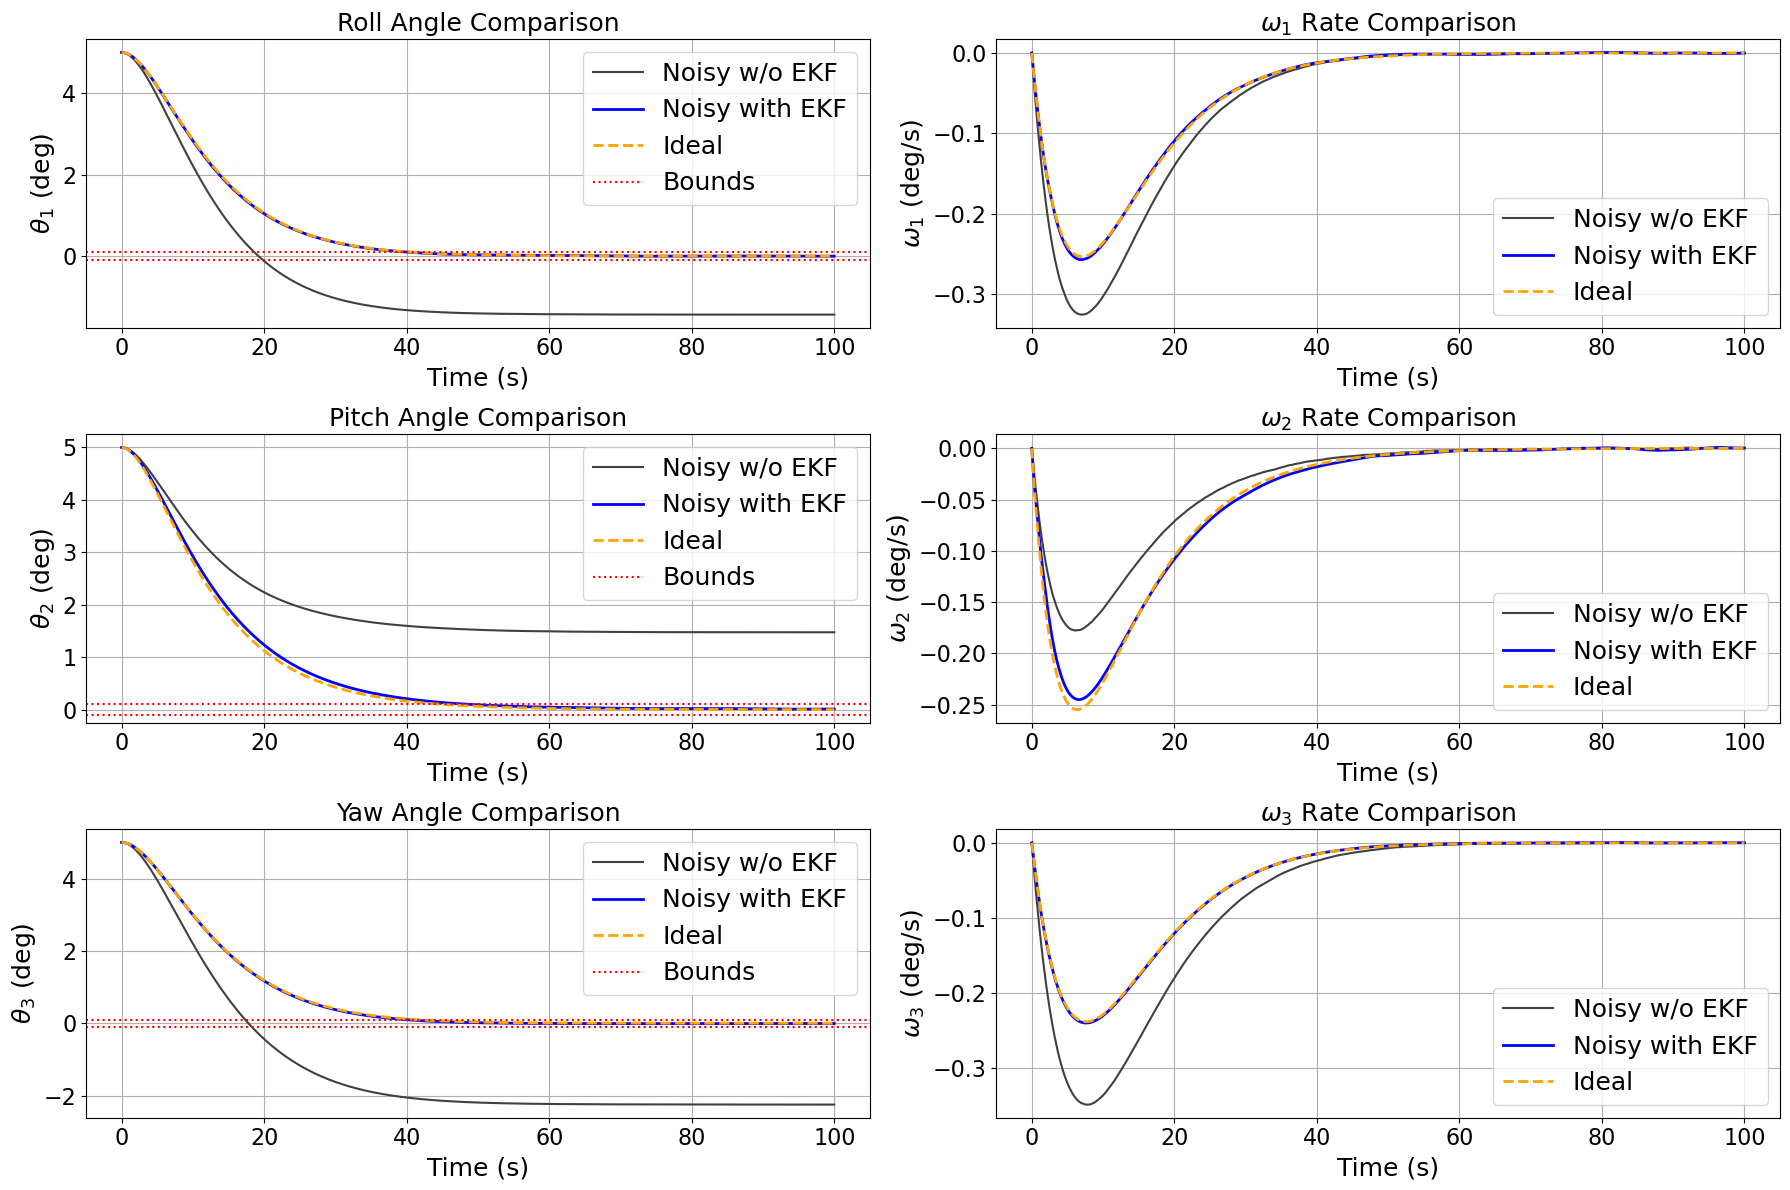

In [7]:
#plotting for the results: 

# plotting for the results:

# Comparing the states w/ and w/o EKF using Greek symbols and subscripts
fig, axs = plt.subplots(3, 2, figsize=(18, 12))

# Roll
axs[0, 0].plot(times, states[0, :] * (180/np.pi), color='0.25', label='Noisy w/o EKF')
axs[0, 0].plot(times, states_EKF[0, :] * (180/np.pi), color='b', linewidth=2, label='Noisy with EKF')
axs[0, 0].plot(times, states_ideal[0, :] * (180/np.pi), linestyle='--', color='#FFA500', linewidth=2, label='Ideal')
axs[0, 0].axhline(0.1, color='r', linestyle=':', label='Bounds')
axs[0, 0].axhline(-0.1, color='r', linestyle=':')
axs[0, 0].set_title(r'Roll Angle Comparison', fontsize=18)
axs[0, 0].set_xlabel('Time (s)', fontsize=18)
axs[0, 0].set_ylabel(r'$\theta_1$ (deg)', fontsize=18)
axs[0, 0].legend(fontsize=18)
axs[0, 0].grid()

# Pitch 
axs[1, 0].plot(times, states[1, :] * (180/np.pi), color='0.25', label='Noisy w/o EKF')
axs[1, 0].plot(times, states_EKF[1, :] * (180/np.pi), color='b', linewidth=2, label='Noisy with EKF')
axs[1, 0].plot(times, states_ideal[1, :] * (180/np.pi), linestyle='--', color='#FFA500', linewidth=2, label='Ideal')
axs[1, 0].axhline(0.1, color='r', linestyle=':', label='Bounds')
axs[1, 0].axhline(-0.1, color='r', linestyle=':')
axs[1, 0].set_title(r'Pitch Angle Comparison', fontsize=18)
axs[1, 0].set_xlabel('Time (s)', fontsize=18)
axs[1, 0].set_ylabel(r'$\theta_2$ (deg)', fontsize=18)
axs[1, 0].legend(fontsize=18)
axs[1, 0].grid()

# Yaw
axs[2, 0].plot(times, states[2, :] * (180/np.pi), color='0.25', label='Noisy w/o EKF')
axs[2, 0].plot(times, states_EKF[2, :] * (180/np.pi), color='b', linewidth=2, label='Noisy with EKF')
axs[2, 0].plot(times, states_ideal[2, :] * (180/np.pi), linestyle='--', color='#FFA500', linewidth=2, label='Ideal')
axs[2, 0].axhline(0.1, color='r', linestyle=':', label='Bounds')
axs[2, 0].axhline(-0.1, color='r', linestyle=':')
axs[2, 0].set_title(r'Yaw Angle Comparison', fontsize=18)
axs[2, 0].set_xlabel('Time (s)', fontsize=18)
axs[2, 0].set_ylabel(r'$\theta_3$ (deg)', fontsize=18)
axs[2, 0].legend(fontsize=18)
axs[2, 0].grid()

# Roll rate
axs[0, 1].plot(times, states[3, :] * (180/np.pi), color='0.25', label='Noisy w/o EKF')
axs[0, 1].plot(times, states_EKF[3, :] * (180/np.pi), color='b', linewidth=2, label='Noisy with EKF')
axs[0, 1].plot(times, states_ideal[3, :] * (180/np.pi), linestyle='--', color='#FFA500', linewidth=2, label='Ideal')
axs[0, 1].set_title(r'$\omega_1$ Rate Comparison', fontsize=18)
axs[0, 1].set_xlabel('Time (s)', fontsize=18)
axs[0, 1].set_ylabel(r'$\omega_1$ (deg/s)', fontsize=18)
axs[0, 1].legend(fontsize=18)
axs[0, 1].grid()

# Pitch rate
axs[1, 1].plot(times, states[4, :] * (180/np.pi), color='0.25', label='Noisy w/o EKF')
axs[1, 1].plot(times, states_EKF[4, :] * (180/np.pi), color='b', linewidth=2, label='Noisy with EKF')
axs[1, 1].plot(times, states_ideal[4, :] * (180/np.pi), linestyle='--', color='#FFA500', linewidth=2, label='Ideal')
axs[1, 1].set_title(r'$\omega_2$ Rate Comparison', fontsize=18)
axs[1, 1].set_xlabel('Time (s)', fontsize=18)
axs[1, 1].set_ylabel(r'$\omega_2$ (deg/s)', fontsize=18)
axs[1, 1].legend(fontsize=18)
axs[1, 1].grid()

# Yaw rate
axs[2, 1].plot(times, states[5, :] * (180/np.pi), color='0.25', label='Noisy w/o EKF')
axs[2, 1].plot(times, states_EKF[5, :] * (180/np.pi), color='b', linewidth=2, label='Noisy with EKF')
axs[2, 1].plot(times, states_ideal[5, :] * (180/np.pi), linestyle='--', color='#FFA500', linewidth=2, label='Ideal')
axs[2, 1].set_title(r'$\omega_3$ Rate Comparison', fontsize=18)
axs[2, 1].set_xlabel('Time (s)', fontsize=18)
axs[2, 1].set_ylabel(r'$\omega_3$ (deg/s)', fontsize=18)
axs[2, 1].legend(fontsize=18)
axs[2, 1].grid()

# Adjust tick label size and layout
for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()
plt.savefig('final_comparison.pdf')
plt.show()

